<a href="https://colab.research.google.com/github/andersonjhones/Modelo-Prophet-com-Python/blob/main/PROPHET_Model_With_Python_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q plotly

In [2]:
!pip install -q -U statsmodels

     |████████████████████████████████| 9.8 MB 23.5 MB/s 


In [3]:
!pip install -q fbprophet

In [4]:
!pip install -q convertdate

In [24]:

#  manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series

#  visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#  modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
import fbprophet
from fbprophet import Prophet

#  métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 14
m.rcParams['ytick.labelsize'] = 14
m.rcParams['text.color'] = 'black'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 18,8
m.style.use('ggplot')
%matplotlib inline

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#import pandas as pd
arquivo = pd.read_excel('/content/drive/MyDrive/data/data.xlsx')

In [11]:
#Visualização dos dados
arquivo.head()

,Time,Ppv
0,2021-09-01 05:39:04,0.0
1,2021-09-01 05:44:05,0.0
2,2021-09-01 05:49:06,41.9
3,2021-09-01 05:54:06,56.1
4,2021-09-01 05:59:06,68.0


In [12]:
arquivo.dropna(how='all')

,Time,Ppv
0,2021-09-01 05:39:04,0.0
1,2021-09-01 05:44:05,0.0
2,2021-09-01 05:49:06,41.9
3,2021-09-01 05:54:06,56.1
4,2021-09-01 05:59:06,68.0
...,...,...
4739,2021-09-30 17:25:47,18.3
4740,2021-09-30 17:30:48,13.6
4741,2021-09-30 17:35:48,9.9
4742,2021-09-30 17:40:48,9.0


In [13]:
#Tipo dos dados
type(arquivo['Ppv'])

pandas.core.series.Series

In [14]:
#Colocando Time como índice
arquivo=arquivo.set_index('Time')

In [15]:
Ppv_work = arquivo[['Ppv']]

In [16]:
Ppv_work

,Ppv
Time,
2021-09-01 05:39:04,0.0
2021-09-01 05:44:05,0.0
2021-09-01 05:49:06,41.9
2021-09-01 05:54:06,56.1
2021-09-01 05:59:06,68.0
...,...
2021-09-30 17:25:47,18.3
2021-09-30 17:30:48,13.6
2021-09-30 17:35:48,9.9


In [17]:
type(Ppv_work.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [18]:
Ppv_work.index= pd.to_datetime(Ppv_work.index)

In [19]:
type(Ppv_work.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [20]:
#Rearranjando o dataset por dia
Ppv_work_mes = Ppv_work['Ppv'].resample('D').mean()

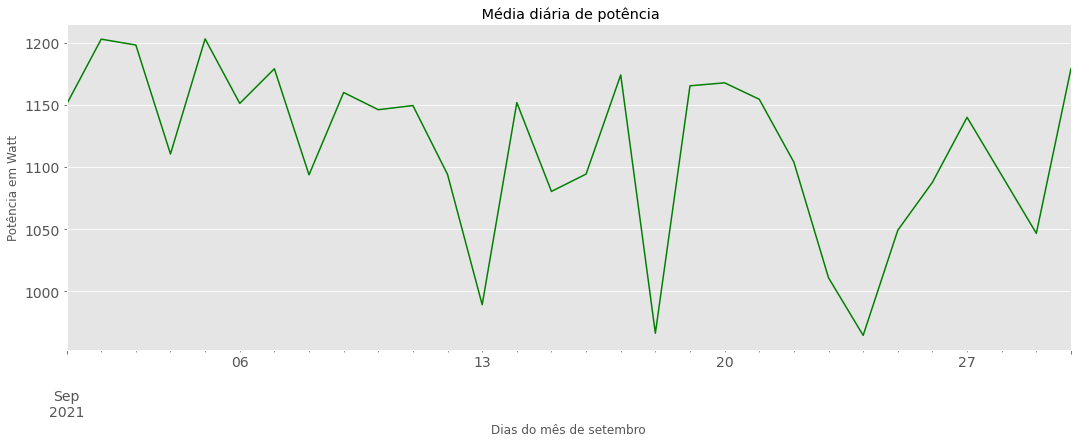

In [116]:
Ppv_work_mes.plot(figsize = (18, 6), color = 'green')
plt.xlabel("Dias do mês de setembro")
plt.ylabel('Potência em Watt')
plt.title(" Média diária de potência")
plt.show()

In [27]:
PPV = Ppv_work_mes.dropna(how='all')

In [28]:
from statsmodels.tsa.stattools import adfuller

#Teste de Dickey-Fuller 
adfuller(PPV)



(-4.288381451484359,
 0.00046524778556684184,
 0,
 29,
 {'1%': -3.6790595944893187,
  '10%': -2.6231583472057074,
  '5%': -2.9678817237279103},
 229.48577604700233)

In [50]:
PPV.shape

(30,)

In [31]:
# Divisão em treino e teste
dados = PPV
train = int(len(dados) * 0.75)
treino, teste = dados[0:train], dados[train:]

In [32]:
# Criação dataframes para dados de treino e teste
arquivo_treino = pd.DataFrame({'Time':treino.index, 'Ppv':treino.values})
arquivo_teste = pd.DataFrame({'Time':teste.index, 'Ppv':teste.values})

In [33]:
# Renomeando as colunas, pois o Prophet requer o nome específico, 'ds' e 'y'. 
arquivo_treino = arquivo_treino.rename(columns = {'Time': 'ds', 'Ppv': 'y'})
arquivo_teste = arquivo_teste.rename(columns = {'Time': 'ds', 'Ppv': 'y'})

In [34]:
# Cria o modelo Prophet com sazonalidade diária com intervalo de confiança de 95 %
# 
modelo_prophet = Prophet(interval_width = 0.95, daily_seasonality = True)

In [35]:
# Treinamento do modelo
modelo_prophet.fit(arquivo_treino) 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


In [92]:
# Dataset para as previsões Diárias
dataset_Dia_para_previsoes = modelo_prophet.make_future_dataframe(periods = 50, freq = 'D')
dataset_Dia_para_previsoes.count()

ds    72
dtype: int64

In [93]:
# PREDIÇÕES FUTURAS
Futuro_modelo_prophet = modelo_prophet.predict(dataset_Dia_para_previsoes)

In [94]:
# previsões feitas pelo modelo
Futuro_modelo_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-09-01,1142.920145,1055.046241,1235.238235
1,2021-09-02,1176.574614,1091.214415,1266.075877
2,2021-09-03,1196.960924,1107.766345,1287.274605
3,2021-09-04,1099.329846,1011.242957,1188.558528
4,2021-09-05,1178.176801,1090.189427,1267.433705


In [95]:
# Algumas das previsões feitas pelo modelo (valor predito e limites de confiança mais baixo e mais alto)
Futuro_modelo_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
67,2021-11-07,970.454759,882.209558,1062.824278
68,2021-11-08,918.996235,830.748178,1017.120512
69,2021-11-09,978.274871,888.021507,1066.878483
70,2021-11-10,911.674379,828.246020,997.261413
71,2021-11-11,945.474673,852.611736,1036.996410


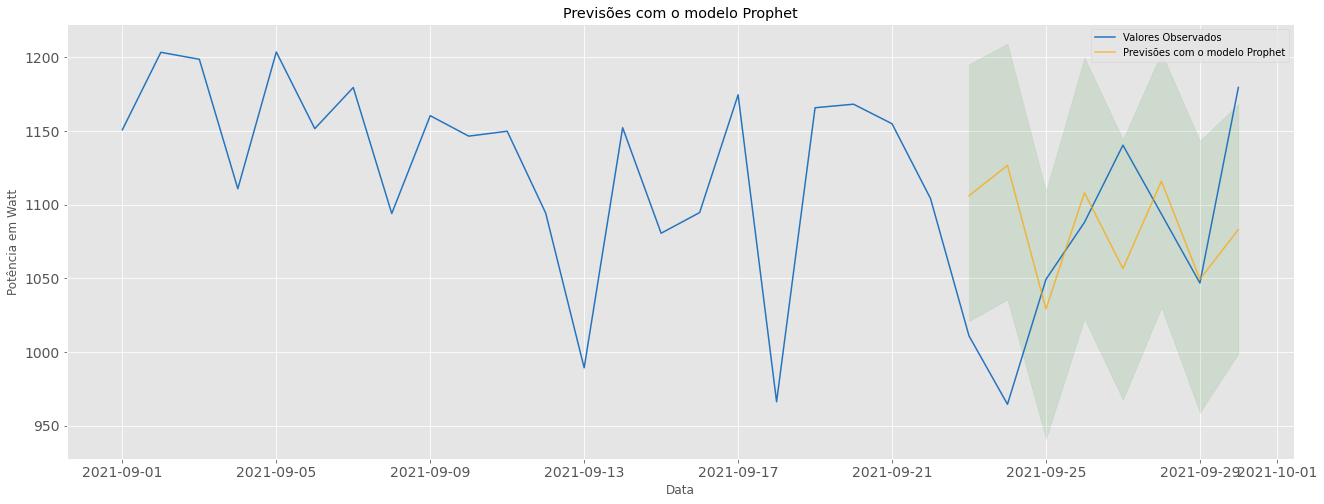

In [96]:
# Plot

# Série original
plt.figure(figsize = (22, 8))
plt.plot(Ppv_work_mes.index, 
         Ppv_work_mes.values,
         label = 'Valores Observados',
         color = '#2574BF')

# Previsões

plt.plot(Ppv_work_mes[22:30].index, 
         Futuro_modelo_prophet[22:30]['yhat'].values,
         label = 'Previsões com o modelo Prophet', 
         alpha = 0.7, 
         color = 'orange'
         )

# Limites de Confiança
plt.fill_between(Ppv_work_mes[22:30].index,
                 Futuro_modelo_prophet[22:30]['yhat_lower'].values,
                 Futuro_modelo_prophet[22:30]['yhat_upper'].values, 
                 color = 'green', 
                 alpha = 0.1)

plt.title('Previsões com o modelo Prophet')
plt.xlabel('Data')
plt.ylabel('Potência em Watt')
plt.legend()
plt.show()

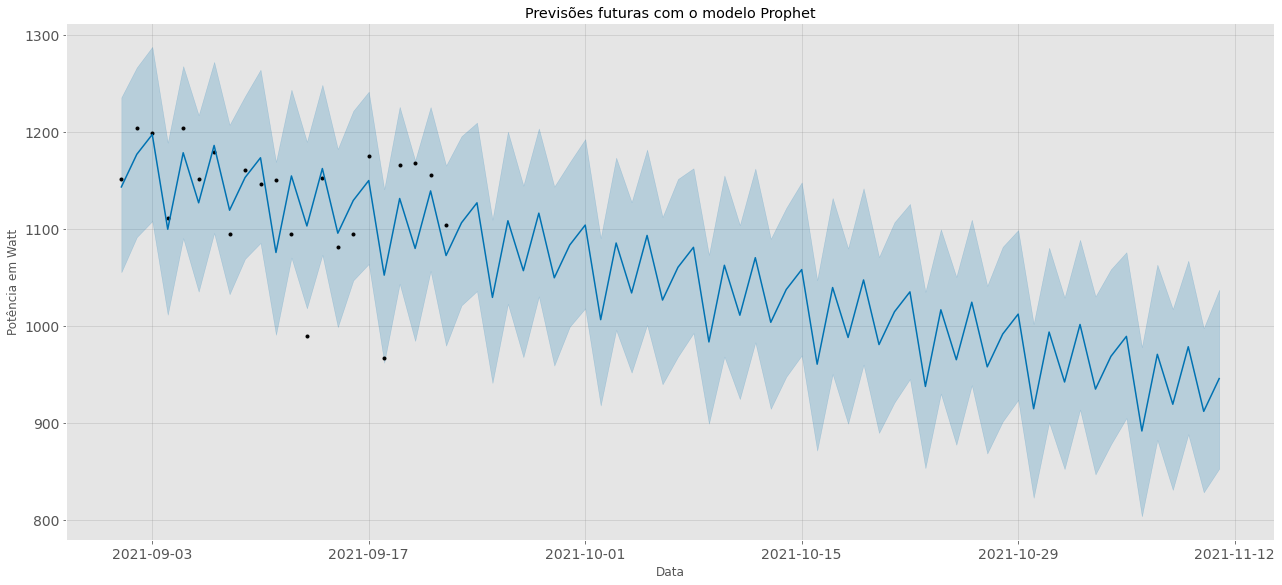

In [97]:
#Previsões futuras
Saida = modelo_prophet.plot(Futuro_modelo_prophet, figsize = (18, 8))
plt.title('Previsões futuras com o modelo Prophet')
plt.xlabel('Data')
plt.ylabel('Potência em Watt')
plt.show()

In [98]:
#  Valores gerados pelas previsões do Prophet:
Futuro_modelo_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-09-01,68.684034,1055.046241,1235.238235,68.684034,68.684034,1074.236111,1074.236111,1074.236111,1099.619343,1099.619343,1099.619343,-25.383232,-25.383232,-25.383232,0.0,0.0,0.0,1142.920145
1,2021-09-02,65.261006,1091.214415,1266.075877,65.261006,65.261006,1111.313608,1111.313608,1111.313608,1099.619343,1099.619343,1099.619343,11.694265,11.694265,11.694265,0.0,0.0,0.0,1176.574614
2,2021-09-03,61.837978,1107.766345,1287.274605,61.837978,61.837978,1135.122946,1135.122946,1135.122946,1099.619343,1099.619343,1099.619343,35.503603,35.503603,35.503603,0.0,0.0,0.0,1196.960924
3,2021-09-04,58.414950,1011.242957,1188.558528,58.414950,58.414950,1040.914896,1040.914896,1040.914896,1099.619343,1099.619343,1099.619343,-58.704447,-58.704447,-58.704447,0.0,0.0,0.0,1099.329846
4,2021-09-05,54.991921,1090.189427,1267.433705,54.991921,54.991921,1123.184880,1123.184880,1123.184880,1099.619343,1099.619343,1099.619343,23.565537,23.565537,23.565537,0.0,0.0,0.0,1178.176801


#Cálculo de métricas para o modelo Prophet


In [99]:
predictions=Futuro_modelo_prophet[22:30]['yhat']

In [100]:
from sklearn.metrics import mean_squared_error
from math import sqrt

RMSE = sqrt(mean_squared_error(teste, predictions))
print('RMSE = ', RMSE)

RMSE =  81.32864283788035


In [101]:
MSE = RMSE**(2)
print('MSE = ', MSE)

MSE =  6614.348145851507


#Componentes do modelo com sazonalidade aditiva

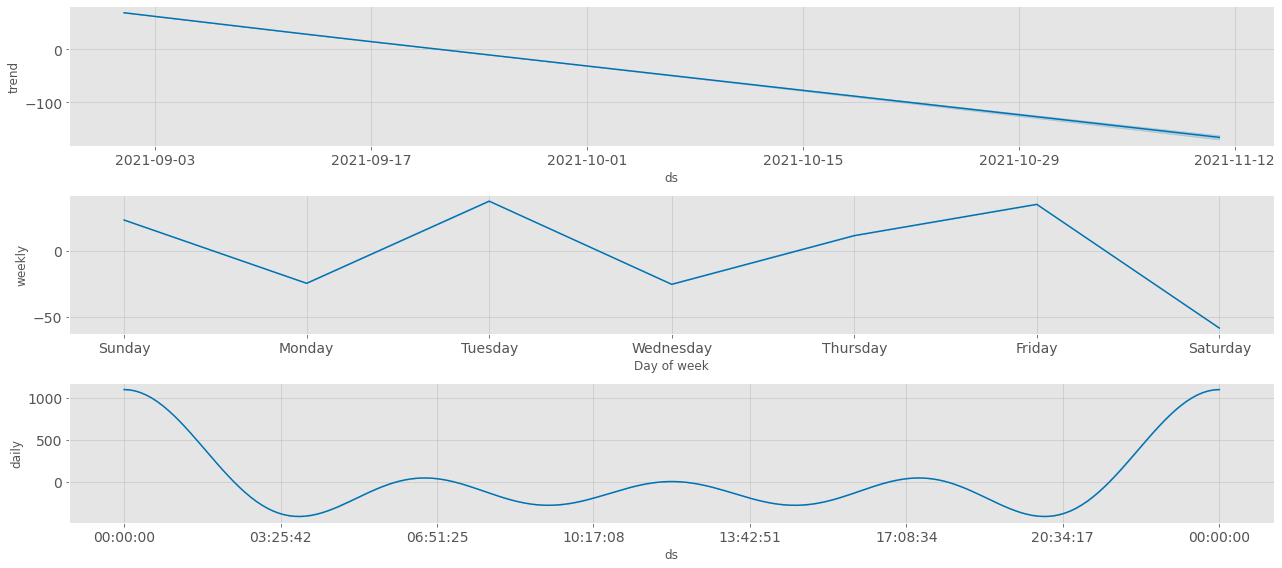

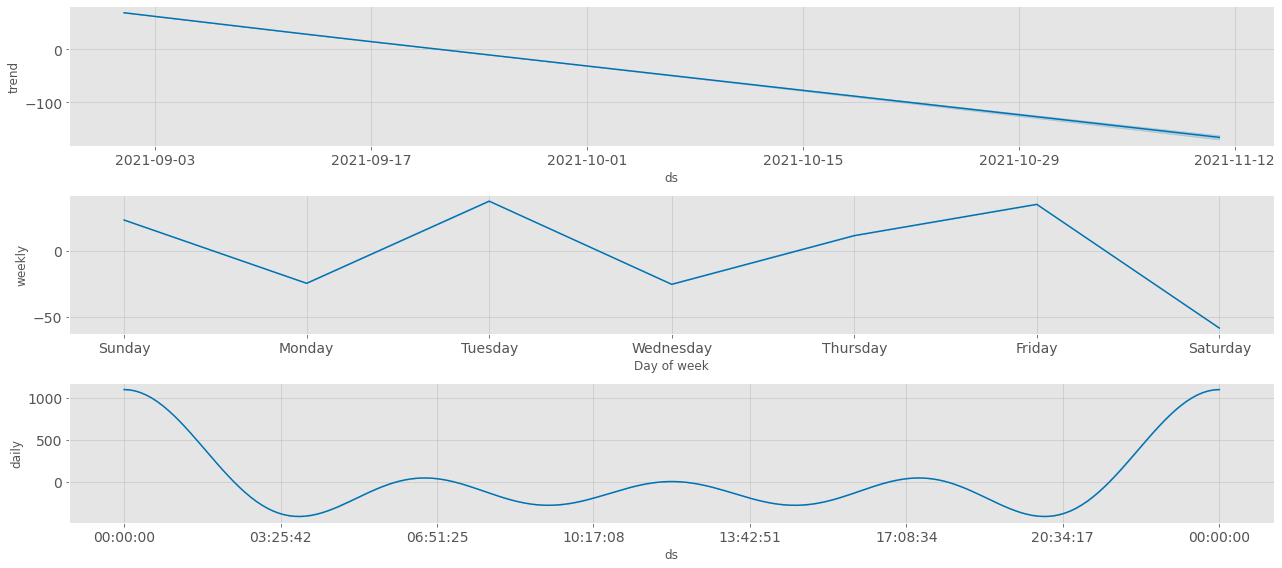

In [102]:
modelo_prophet.plot_components(Futuro_modelo_prophet, figsize = (18, 8))

#Treinando o modelo com sazonalidade multiplicativa

In [103]:
modelo_prophet_2 = Prophet(interval_width = 0.95, daily_seasonality = True, seasonality_mode='multiplicative')

In [104]:
# Treinamento do modelo
modelo_prophet_2.fit(arquivo_treino) 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


In [105]:
# Dataset para as previsões Diárias
dataset_Dia_para_previsoes_2 = modelo_prophet_2.make_future_dataframe(periods = 50, freq = 'D')
dataset_Dia_para_previsoes_2.count()

ds    72
dtype: int64

In [106]:
# PREDIÇÕES FUTURAS
Futuro_modelo_prophet_2 = modelo_prophet_2.predict(dataset_Dia_para_previsoes_2)

In [107]:
# previsões feitas pelo modelo
Futuro_modelo_prophet_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-09-01,1141.332377,1044.606355,1230.875158
1,2021-09-02,1176.743192,1085.326280,1269.964497
2,2021-09-03,1197.062103,1103.850674,1284.657055
3,2021-09-04,1098.349210,1010.226399,1186.872245
4,2021-09-05,1178.204234,1095.579032,1270.362662


In [108]:
# Algumas das previsões feitas pelo modelo
Futuro_modelo_prophet_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
67,2021-11-07,965.638937,871.942317,1052.580364
68,2021-11-08,921.706682,830.030163,1014.609282
69,2021-11-09,970.910064,888.237270,1062.364926
70,2021-11-10,914.999911,826.474205,1005.608632
71,2021-11-11,942.772631,856.923603,1027.233330


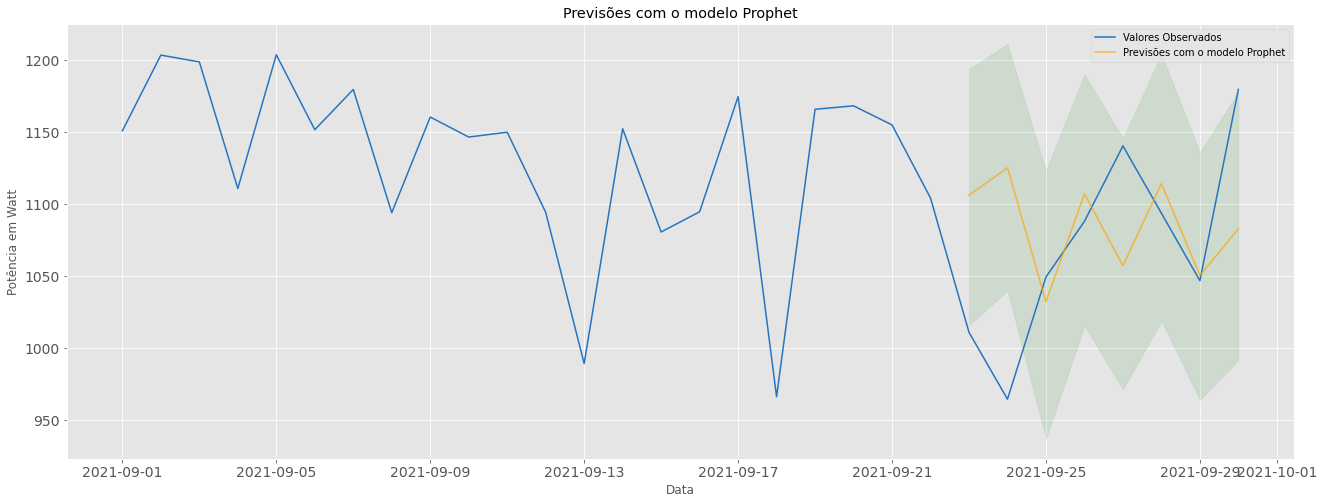

In [109]:
# Plot

# Série original
plt.figure(figsize = (22, 8))
plt.plot(Ppv_work_mes.index, 
         Ppv_work_mes.values,
         label = 'Valores Observados',
         color = '#2574BF')

# Previsões

plt.plot(Ppv_work_mes[22:30].index, 
         Futuro_modelo_prophet_2[22:30]['yhat'].values,
         label = 'Previsões com o modelo Prophet', 
         alpha = 0.7, 
         color = 'orange'
         )

# Limites de Confiança
plt.fill_between(Ppv_work_mes[22:30].index,
                 Futuro_modelo_prophet_2[22:30]['yhat_lower'].values,
                 Futuro_modelo_prophet_2[22:30]['yhat_upper'].values, 
                 color = 'green', 
                 alpha = 0.1)

plt.title('Previsões com o modelo Prophet')
plt.xlabel('Data')
plt.ylabel('Potência em Watt')
plt.legend()
plt.show()

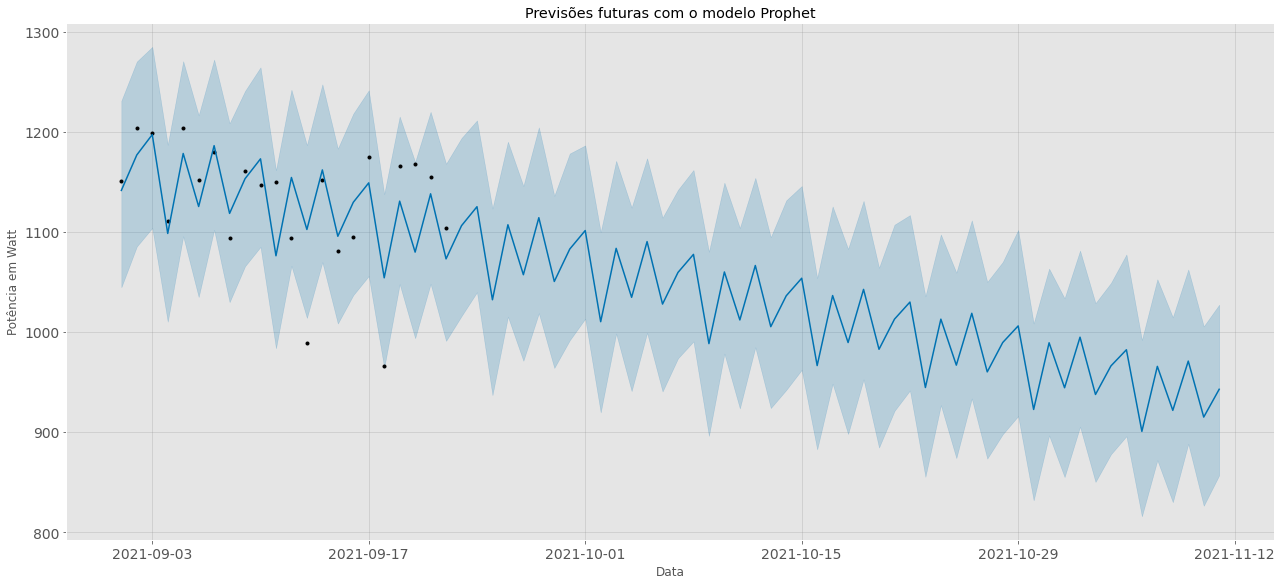

In [110]:
Saida_2 = modelo_prophet_2.plot(Futuro_modelo_prophet_2, figsize = (18, 8))
plt.title('Previsões futuras com o modelo Prophet')
plt.xlabel('Data')
plt.ylabel('Potência em Watt')
plt.show()

In [111]:
# As previsões do Prophet retornam diversos valores:
Futuro_modelo_prophet_2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-09-01,1445.039601,1044.606355,1230.875158,1445.039601,1445.039601,-0.191944,-0.191944,-0.191944,-0.210172,-0.210172,-0.210172,-0.018228,-0.018228,-0.018228,0.0,0.0,0.0,1141.332377
1,2021-09-02,1440.888869,1085.326280,1269.964497,1440.888869,1440.888869,-0.191944,-0.191944,-0.191944,-0.183321,-0.183321,-0.183321,0.008622,0.008622,0.008622,0.0,0.0,0.0,1176.743192
2,2021-09-03,1436.738137,1103.850674,1284.657055,1436.738137,1436.738137,-0.191944,-0.191944,-0.191944,-0.166820,-0.166820,-0.166820,0.025124,0.025124,0.025124,0.0,0.0,0.0,1197.062103
3,2021-09-04,1432.587405,1010.226399,1186.872245,1432.587405,1432.587405,-0.191944,-0.191944,-0.191944,-0.233311,-0.233311,-0.233311,-0.041367,-0.041367,-0.041367,0.0,0.0,0.0,1098.349210
4,2021-09-05,1428.436674,1095.579032,1270.362662,1428.436674,1428.436674,-0.191944,-0.191944,-0.191944,-0.175179,-0.175179,-0.175179,0.016765,0.016765,0.016765,0.0,0.0,0.0,1178.204234


#Métricas para o modelo Prophet com sazonalidade multiplicativa

In [112]:
predictions_2=Futuro_modelo_prophet_2[22:30]['yhat']

In [113]:
RMSE_2 = sqrt(mean_squared_error(teste, predictions_2))
print('RMSE = ', RMSE_2)

RMSE =  80.76727550364616


In [114]:
MSE_2 = RMSE_2**(2)
print('MSE = ', MSE_2)

MSE =  6523.352792281881


#Componentes do modelo com sazonalidade multiplicativa

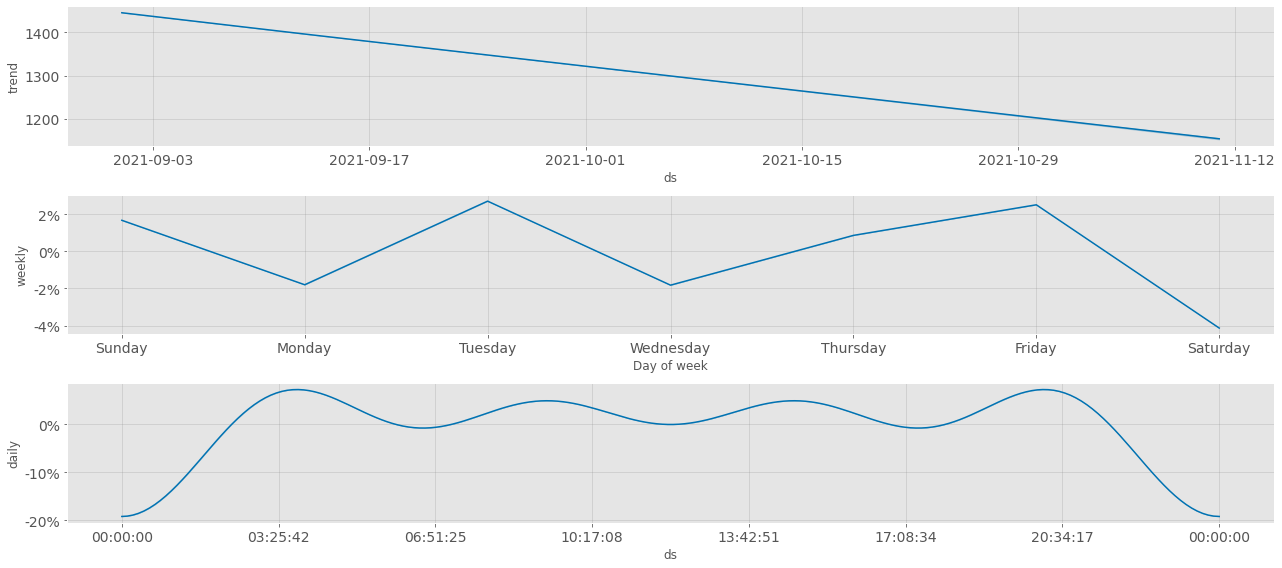

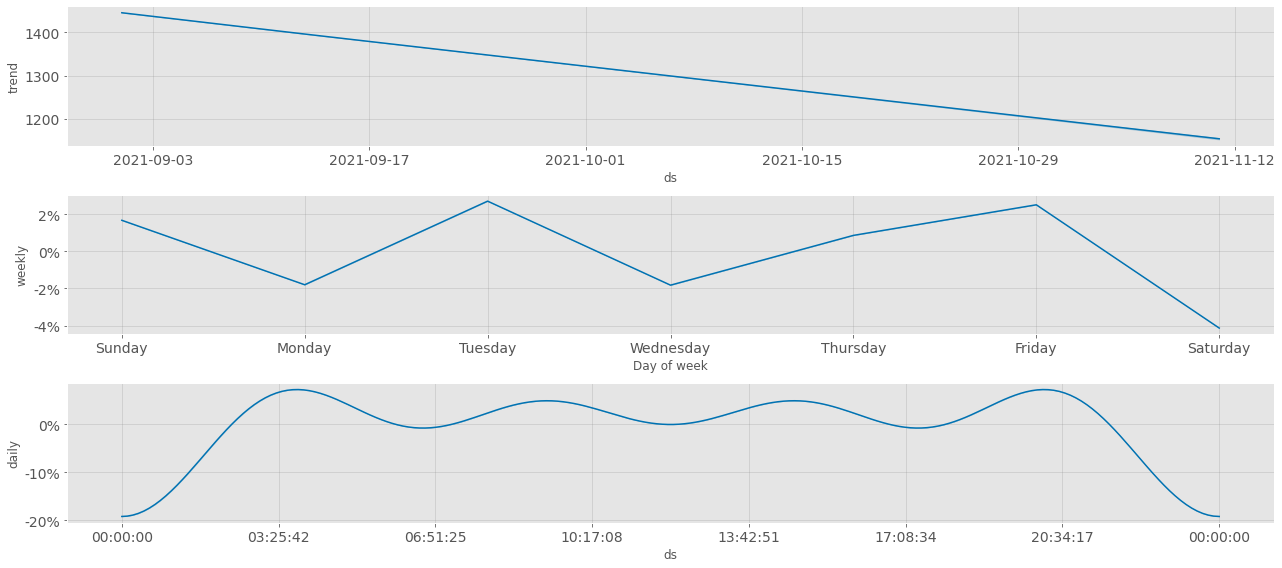

In [115]:
modelo_prophet_2.plot_components(Futuro_modelo_prophet_2, figsize = (18, 8))

# O banco de dados utilizado apresenta valor-p muito baixo (Cerca de 0,046%), logo pode-se concluir que está série é estacionária e sua média e desvio padrão praticamente não variam ao longo do tempo. Então as respostas do modelo com sazonalidade aditiva ou multiplicativa foi praticamente a mesma. Se a série temporal apresenta-se uma forte tendência de queda ou de crescimento, provavelmente o modelo se sairia melhor com o parâmetro padrão setado pelo prophet, que é a sozonalidade aditiva. No entanto, se os dados históricos apresentacem forte sazonalidade, talvez o modelo com sazonalidade multiplicativa seria o mais indicado. O intuito de aplicar o Prophet nesta série foi mais para fins didáticos, mas você pode treinar seu modelo e fazer previsões com séries temporais não estacionárias.